In [932]:
import numpy as np

In [852]:
import sys
sys.path.insert(1,'../../python/')

In [853]:
from utils import *

Define parameters for the QPM mocks:

In [854]:
class QPM_Parameters:
    """Holds covariance matrix parameters for the QPM matrices. These are initially set to default values"""
    def __init__(self,mock_no,mean=False):
        self.n=36
        self.m=10
        self.a=1
        self.n_indiv=20
        if mean:
            self.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Mean_HiRes/'
        else:
            self.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_CovariancesFine2/Mock_%d/'%mock_no
        self.weights_file='/mnt/store1/oliverphilcox/CMU/weightfiles/jackknife_weights_n36_m10_j169.dat'
        self.RR_file = '/mnt/store1/oliverphilcox/CMU/weightfiles/binned_pair_counts_n36_m10_j169.dat'
        self.r_bins = np.loadtxt('../../python/binfile_linear.csv')         

Load the covariance matrix from the mean of the 1000 QPM Mocks

In [855]:
p=QPM_Parameters(0,mean=True)
p.n_indiv=100
qpm_mean=CovarianceMatrix(p)

Compute N_eff

In [856]:
qpm_mean.compute_N_eff()

Total N_eff Estimate: 6.235222e+06


6235222.065005239

In [857]:
qpm_mean.compute_precision()

General KL divergence function:

In [858]:
def KL_divergence(precision,covariance):
    """Return the negative log likelihood of the KL divergence between two matrices, one of which is inverted.
    The matrix known to higher precision should be inverted.
    i.e. 2KL = Trace(precision*covariance) - log(det(precision)) - log(det(covariance)) - N_bins"""
    product = np.matmul(precision,covariance);
    N_bins=len(precision)
    logdetPrec = np.linalg.slogdet(precision)
    logdetCov = np.linalg.slogdet(covariance)
    if logdetPrec[0]!=1.:
        raise Exception('Undefined determinant for precision matrix')
    if logdetCov[0]!=1.:
        raise Exception('Undefined determinant for covariance matrix')
    KL = 0.5*(np.matrix.trace(product) - logdetPrec[1] - logdetCov[1] - N_bins)
    return KL

Compute KL divergence between $\psi$ from all mocks and $C$ for each mock (run for 30 minutes each, with $N_\mathrm{eff}\sim1\times10^5$).

In [ ]:
KL_divs=[];v_mock=[]
for i in range(1,61):
    p_QPM=QPM_Parameters(i)
    this_covariance=CovarianceMatrix(p_QPM)
    KL_divs.append(KL_divergence(qpm_mean.prec,this_covariance.c_tot))
    v_mock.append(np.linalg.slogdet(this_covariance.c_tot)[1]/len(this_covariance.c_tot))

Compute $v$ for the direct mean-of-100 mocks:

In [ ]:
p_QPM=QPM_Parameters(i)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_CovariancesFine2/MarianaMean/'
qpm_mean100=CovarianceMatrix(p_QPM)
v_mean100=np.linalg.slogdet(qpm_mean100.c_tot)[1]/len(qpm_mean100.c_tot)

Compute $|C_{[i]}|$ per bin for each QPM mock matrix:

In [ ]:
v_mean = np.linalg.slogdet(qpm_mean.c_tot)[1]/len(qpm_mean.c_tot)

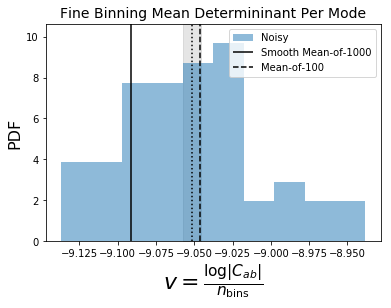

In [946]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')
x,y,z=plt.hist(v_mock,density=True,alpha=0.5,label=r'Noisy');FS=16
#plt.hist(v_mock_small,density=True,alpha=0.5,label='10 Samples');plt.legend();
plt.vlines(v_mean,0,max(x)*1.1,label=r'Smooth Mean-of-1000');plt.ylim([0,max(x)*1.1])
plt.vlines(v_mean100,0,max(x)*1.1,label=r'Mean-of-100',linestyles='dashed');
plt.vlines(np.mean(v_mock),0,max(x)*1.1,linestyles='dotted')
mean,err=np.mean(v_mock),np.std(v_mock)/np.sqrt(len(v_mock))
yvals=np.linspace(0,max(x)*1.1,100)
plt.fill_betweenx(yvals,np.ones(100)*(mean-err),np.ones(100)*(mean+err),alpha=0.1,color='k')
plt.legend(fontsize=FS-6)
plt.title('Fine Binning Mean Determininant Per Mode',fontsize=FS-2)
plt.ylabel('PDF',fontsize=FS);plt.xlabel(r'$v = \frac{\log{}|C_{ab}|}{n_\mathrm{bins}}$',fontsize=FS+6);
#plt.savefig('../../plots/FineMeanDetPerMode.pdf',bbox_inches='tight')

In [940]:
sample_mean=np.mean(v_mock)
#sample_mean_small=np.mean(v_mock_small)
sample_std=np.std(v_mock)/np.sqrt(len(v_mock))
#sample_std_small=np.std(v_mock_small)/np.sqrt(len(v_mock_small))
print("Sample Statistics - Mean: %.2e+-%.2e   True-1000: %.2e   True-100: %.2e"%(sample_mean,sample_std,v_mean,v_mean100))
#print("10 Samples - Mean: %.2e+-%.2e   True: %.2e"%(sample_mean_small,sample_std_small,v_mean))

Sample Statistics - Mean: -9.05e+00+-6.10e-03   True-1000: -9.09e+00   True-100: -9.05e+00


In [942]:
print("Smoothed Mean-of-1000:")
print("Difference: %.2f%%"%((v_mean-sample_mean)/v_mean*100))
print("Significance: %.2f sigma"%((v_mean-sample_mean)/sample_std))


print("Unsmoothed Mean-of-100:")
print("Difference: %.2f%%"%((v_mean100-sample_mean)/v_mean100*100))
print("Significance: %.2f sigma"%((v_mean100-sample_mean)/sample_std))

#print("\n10 Samples:")
#print("Difference: %.2f%%"%((v_mean-sample_mean_small)/v_mean*100))
#print("Significance: %.2f sigma"%((v_mean-sample_mean_small)/sample_std_small))

Smoothed Mean-of-1000:
Difference: 0.44%
Significance: -6.51 sigma
Unsmoothed Mean-of-100:
Difference: -0.06%
Significance: 0.87 sigma


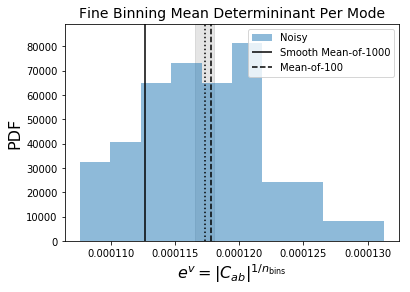

In [947]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')
x,y,z=plt.hist(np.exp(v_mock),density=True,alpha=0.5,label=r'Noisy');FS=16
#plt.hist(v_mock_small,density=True,alpha=0.5,label='10 Samples');plt.legend();
plt.vlines(np.exp(v_mean),0,max(x)*1.1,label=r'Smooth Mean-of-1000');plt.ylim([0,max(x)*1.1])
plt.vlines(np.mean(np.exp(v_mock)),0,max(x)*1.1,linestyles='dotted')
plt.vlines(np.exp(v_mean100),0,max(x)*1.1,label=r'Mean-of-100',linestyles='dashed')
mean,err=np.mean(np.exp(v_mock)),np.std(np.exp(v_mock))/np.sqrt(len(v_mock))
yvals=np.linspace(0,max(x)*1.1,100)
plt.fill_betweenx(yvals,np.ones(100)*(mean-err),np.ones(100)*(mean+err),alpha=0.1,color='k')
plt.legend(fontsize=FS-6)
plt.title('Fine Binning Mean Determininant Per Mode',fontsize=FS-2)
plt.ylabel('PDF',fontsize=FS);plt.xlabel(r'$e^v = |C_{ab}|^{1/n_\mathrm{bins}}$',fontsize=FS);
plt.savefig('../../plots/FineMeanDetPerModeExpon.pdf',bbox_inches='tight')

In [866]:
mean-err,mean+err

(0.00011601280189168427, 0.00011791373146055145)

In [867]:
print("20 Samples:")
print("Difference: %.2f%%"%((np.exp(v_mean)-mean)/np.exp(v_mean)*100))
print("Significance: %.2f sigma"%((np.exp(v_mean)-np.mean(np.exp(v_mock)))/np.std(np.exp(v_mock))*np.sqrt(len(v_mock))))


20 Samples:
Difference: -3.84%
Significance: -4.55 sigma


Now repeat for Coarse data:

In [868]:
v_mock_coarse=[];
for i in range(1,20):
    p_QPM=QPM_Parameters(i)
    p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_CovariancesCoarse2/Mock_%d/'%i
    this_covariance=CovarianceMatrix(p_QPM)
    v_mock_coarse.append(np.linalg.slogdet(this_covariance.c_tot)[1]/len(this_covariance.c_tot))

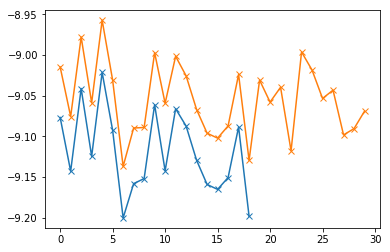

In [869]:
plt.plot(v_mock_coarse,label='Coarse',marker='x')
plt.plot(v_mock,label='Fine',marker='x')

In [870]:
np.mean(np.exp(v_mock_coarse)/np.exp(v_mock[:19]))

0.9369227419698165

Compare Coarse and Fine means, run for same number of samples:

In [875]:
p_QPM=QPM_Parameters(1)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_CovariancesCoarse2/Mean/'
p_QPM.n_indiv=20
coarse_mean=CovarianceMatrix(p_QPM)

p_QPM=QPM_Parameters(1)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_CovariancesFine2/Mean/'
p_QPM.n_indiv=20
fine_mean=CovarianceMatrix(p_QPM)

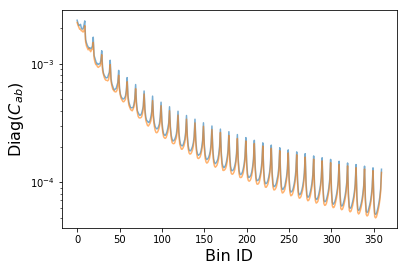

In [876]:
plt.plot(np.diag(fine_mean.c_tot),alpha=.6,label='Fine Mean')
plt.plot(np.diag(coarse_mean.c_tot),alpha=.6,label='Coarse Mean')
plt.ylabel(r'Diag($C_{ab}$)',fontsize=16);plt.xlabel('Bin ID',fontsize=16)
plt.yscale('log')

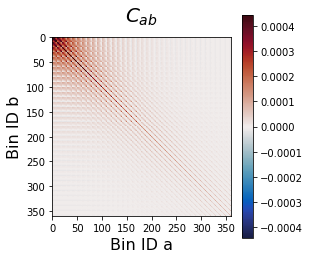

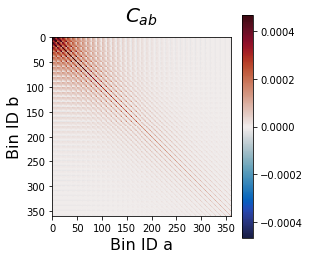

In [877]:
pt.plot_covariance(coarse_mean)
pt.plot_covariance(fine_mean)

In [878]:
fine_mean.compute_precision()
KL_divergence(fine_mean.prec,coarse_mean.c_tot)

0.6497552110624838

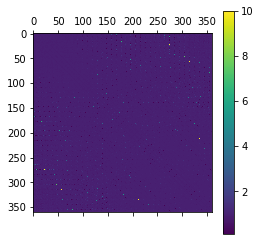

In [928]:
plt.matshow(coarse_mean.c_tot/fine_mean.c_tot,vmax=10,vmin=0.1);
plt.colorbar()

In [931]:
np.mean(coarse_mean.c_tot/fine_mean.c_tot)

0.9808334046753462

Also compute $|\psi\times{}C_{[i]}|-1$ for each mock: 

In [879]:
iden_bin=[]
for i in range(1,30):
    p_QPM=QPM_Parameters(i)
    this_covariance=CovarianceMatrix(p_QPM)
    product=np.matmul(qpm_mean.prec,this_covariance.c_tot)#-np.eye(len(qpm_mean.prec))
    iden_bin.append(np.exp(np.linalg.slogdet(product)[1]/len(product))-1)

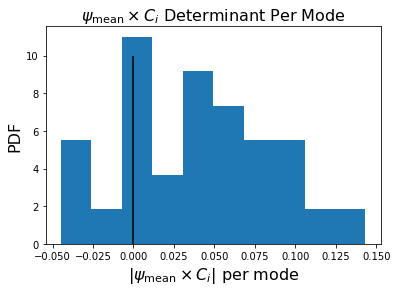

In [880]:
plt.hist(iden_bin,density=True);FS=16
plt.vlines(0.,0,10);
plt.title(r'$\psi_\mathrm{mean}\times{}C_i$ Determinant Per Mode',fontsize=FS)
plt.ylabel('PDF',fontsize=FS);plt.xlabel(r'$|\psi_\mathrm{mean}\times{}C_i|$ per mode',fontsize=FS);

In [881]:
sample_mean=np.mean(iden_bin)
sample_std=np.std(iden_bin)/np.sqrt(len(iden_bin))
print("Mean: %.2e+-%.2e"%(sample_mean,sample_std))
print("Significance: %.2f sigma"%((sample_mean)/sample_std))

Mean: 3.89e-02+-8.71e-03
Significance: 4.46 sigma


Now compute $N_\mathrm{eff}$ and $D_{KL}$ for each estimate of the matrix for a single mock;

In [901]:
partial_covs_indiv=[]
p_QPM=QPM_Parameters(1)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Mock1_HiRes/'
p_QPM.n_indiv=100
qpm_1=CovarianceMatrix(p_QPM)
i_min=5;i_max=p_QPM.n_indiv
for i in range(i_max):
    partial_covs_indiv.append(qpm_1.read_all_matrices(root=str(i)))
samples_indivs=list(np.arange(i_min,i_max,3))
N_effs_indivs=np.zeros(len(samples_indivs))
KL_div_indivs=np.zeros(len(samples_indivs))
for j,ii in enumerate(samples_indivs):
    print("Computing D matrix %d of %d"%(ii,i_max))
    c_tot_mats=partial_covs_indiv[:ii]
    nn = len(c_tot_mats)
    summ=0.
    for i in range(nn):
        c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
        summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
    D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
    slogdetD=np.linalg.slogdet(D_est)
    n_bins = len(D_est)
    D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
    N_effs_indivs[j] = (n_bins+1.)/D_value+1.
    KL_div_indivs[j] = KL_divergence(qpm_mean.prec,np.mean(c_tot_mats,axis=0))

Computing D matrix 5 of 100
Computing D matrix 8 of 100
Computing D matrix 11 of 100
Computing D matrix 14 of 100
Computing D matrix 17 of 100
Computing D matrix 20 of 100
Computing D matrix 23 of 100
Computing D matrix 26 of 100
Computing D matrix 29 of 100
Computing D matrix 32 of 100
Computing D matrix 35 of 100
Computing D matrix 38 of 100
Computing D matrix 41 of 100
Computing D matrix 44 of 100
Computing D matrix 47 of 100
Computing D matrix 50 of 100
Computing D matrix 53 of 100
Computing D matrix 56 of 100
Computing D matrix 59 of 100
Computing D matrix 62 of 100
Computing D matrix 65 of 100
Computing D matrix 68 of 100
Computing D matrix 71 of 100
Computing D matrix 74 of 100
Computing D matrix 77 of 100
Computing D matrix 80 of 100
Computing D matrix 83 of 100
Computing D matrix 86 of 100
Computing D matrix 89 of 100
Computing D matrix 92 of 100
Computing D matrix 95 of 100
Computing D matrix 98 of 100


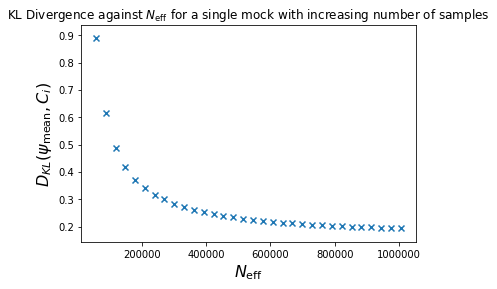

In [902]:
plt.scatter(N_effs_indivs,KL_div_indivs,marker='x');
plt.ylabel(r'$D_{KL}(\psi_\mathrm{mean},C_i)$',fontsize=16);plt.xlabel(r'$N_\mathrm{eff}$',fontsize=16)
plt.title(r'KL Divergence against $N_\mathrm{eff}$ for a single mock with increasing number of samples');

Compute the relevant $N_\mathrm{eff}$ from this:

In [903]:
N_bins = len(qpm_mean.prec)
n_eff_KL_indiv=[N_bins*(N_bins+1)/(4.*KL) for KL in KL_div_indivs]

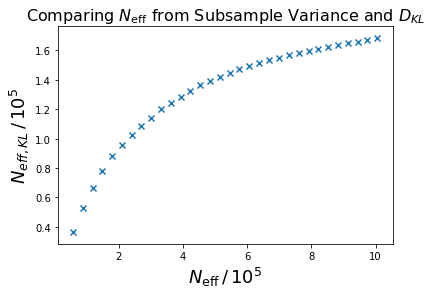

In [904]:
plt.scatter(N_effs_indivs/1e5,np.asarray(n_eff_KL_indiv)/1e5,marker='x');
plt.ylabel(r'$N_{eff,KL}\,/\,10^5$',fontsize=18);plt.xlabel(r'$N_\mathrm{eff}\,/\,10^5$',fontsize=18)
plt.title(r'Comparing $N_\mathrm{eff}$ from Subsample Variance and $D_{KL}$',fontsize=16);
#plt.savefig("../../plots/N_eff_Subsample.pdf",bbox_inches='tight')

In [905]:
D_from_N_eff=[N_bins*(N_bins+1)/(4.*Ne) for Ne in N_effs_indivs]

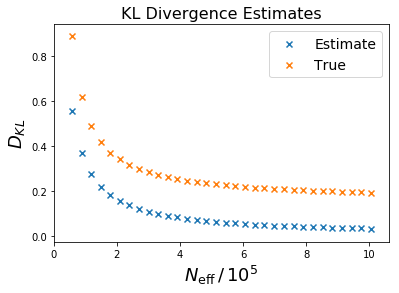

In [906]:
plt.scatter(N_effs_indivs/1e5,np.asarray(D_from_N_eff),marker='x',label='Estimate');
plt.scatter(N_effs_indivs/1e5,np.asarray(KL_div_indivs),marker='x',label='True');
plt.xlabel(r'$N_\mathrm{eff}\,/\,10^5$',fontsize=18);plt.ylabel(r'$D_{KL}$',fontsize=18);plt.legend(fontsize=14)
plt.title(r'KL Divergence Estimates',fontsize=16);
#plt.savefig("../../plots/D_KL_vs_Estimate.pdf",bbox_inches='tight')

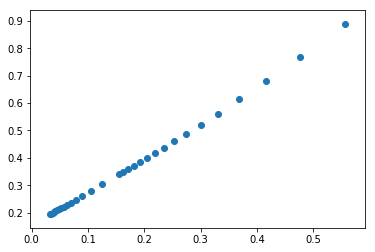

In [897]:
plt.scatter(D_from_N_eff,KL_div_indivs)

In [907]:
N_bins = len(qpm_mean.prec)
n_eff_KL=[N_bins*(N_bins+1)/(4.*KL) for KL in KL_divs]

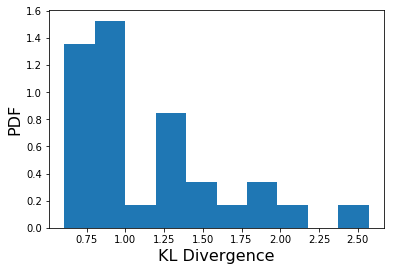

In [908]:
plt.hist(KL_divs,density=True);
plt.ylabel('PDF',fontsize=16);plt.xlabel('KL Divergence',fontsize=16);

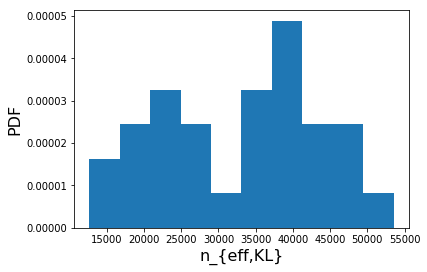

In [909]:
plt.hist(n_eff_KL,density=True); plt.ylabel('PDF',fontsize=16);plt.xlabel('n_{eff,KL}',fontsize=16);

In [498]:
precs=[]
for i in range(1,31):
    p_QPM=QPM_Parameters(i)
    qpm=CovarianceMatrix(p_QPM)
    qpm.compute_N_eff()
    qpm.compute_precision()
    precs.append(qpm.prec)

Total N_eff Estimate: 1.140810e+05


KeyboardInterrupt: 

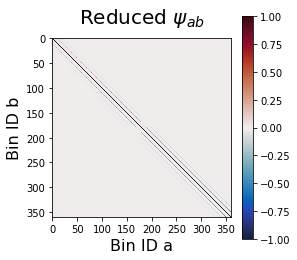

In [566]:
pt=plotting_tools()
pt.plot_reduced_precision(qpm_mean)#,50,100)

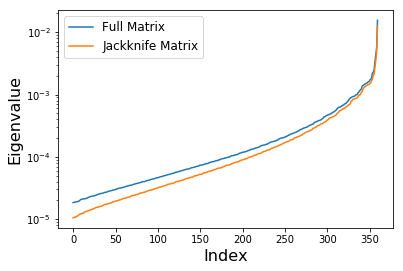

In [567]:
pt=plotting_tools()
pt.plot_eigenvalues(qpm_mean)

# Fisher Modes

In [609]:
fisher=np.loadtxt('/mnt/store1/oliverphilcox/CMU/L_180.csv')

In [613]:
fisher.shape

(4, 350)

## Add in Coarse Graining

Done for Mock 1 here

In [620]:
p_QPM=QPM_Parameters(1,mean=True)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/Coarse1/'
cov_coarse=CovarianceMatrix(p_QPM)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Covariances3/Mock_1/'
cov_fine=CovarianceMatrix(p_QPM)

In [625]:
cov_coarse.compute_precision()
cov_fine.compute_precision()

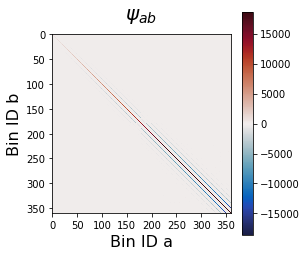

In [624]:
pt.plot_precision(cov_coarse)

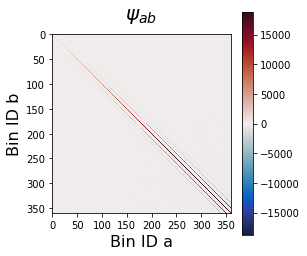

In [626]:
pt.plot_precision(cov_fine)

In [630]:
fine_coarse_div=KL_divergence(cov_fine.prec,cov_coarse.c_tot)
print(fine_coarse_div)
N_bins = len(cov_fine.prec)
N_eff_KL = N_bins*(N_bins+1)/(4.*fine_coarse_div)
print(N_eff_KL)

0.4754239173273618
68339.01033554527


In [210]:
p_QPM=QPM_Parameters(1)
this_covariance=CovarianceMatrix(p_QPM)

Compute N_eff against samples for the mean of the mocks and the individual estimates - does this plateau?

In [537]:
N_effs_indivs_all=[]
for index in range(1,16):
    print(index)
    partial_covs_indiv=[]
    p_QPM=QPM_Parameters(index)
    qpm_1=CovarianceMatrix(p_QPM)
    for i in range(10):
        partial_covs_indiv.append(qpm_1.read_all_matrices(root=str(i)))
    i_min=3;i_max=10
    N_effs_indivs=np.zeros(i_max-i_min)
    samples_indivs=np.arange(i_min,i_max)
    for ii in range(i_min,i_max):
        c_tot_mats=partial_covs_indiv[:ii]
        nn = len(c_tot_mats)
        summ=0.
        for i in range(nn):
            c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
            summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
        D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
        slogdetD=np.linalg.slogdet(D_est)
        n_bins = len(D_est)
        D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
        N_effs_indivs[ii-i_min] = (n_bins+1.)/D_value+1.
    N_effs_indivs_all.append(np.asarray(N_effs_indivs))

1
2
3


KeyboardInterrupt: 

In [271]:
partial_covs=[]
for i in range(40):
    partial_covs.append(qpm_mean.read_all_matrices(root=str(i)))

In [466]:
i_min=5;i_max=40
N_effs=np.zeros(i_max-i_min)
samples_all=np.arange(i_min,i_max)
for ii in range(i_min,i_max):
    
    
    c_tot_mats=partial_covs[:ii]
    nn = len(c_tot_mats)
    summ=0.
    for i in range(nn):
        c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
        summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
    D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
    slogdetD=np.linalg.slogdet(D_est)
    n_bins = len(D_est)
    D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
    N_effs[ii-i_min] = (n_bins+1.)/D_value+1.

In [467]:
mean_N_effs=[np.mean([N[i] for N in N_effs_indivs_all]) for i in range(len(N_effs_indivs_all[0]))]
std_N_effs=[np.std([N[i] for N in N_effs_indivs_all]) for i in range(len(N_effs_indivs_all[0]))]

In [468]:
n_quads_tot=np.loadtxt('/mnt/store1/oliverphilcox/CMU/QPM_MockMean/CovMatricesAll/total_counts_n36_m10_11,11.txt')[-1]    

In [469]:
samples_indivs

array([3, 4, 5, 6, 7, 8, 9])

Compute determinant per mode for hi-res data:

In [922]:
v_hi_mock=np.linalg.slogdet(qpm_mock_big.c_tot)[1]/len(qpm_mock_big.c_tot)
v_hi_mean=np.linalg.slogdet(qpm_mean_big.c_tot)[1]/len(qpm_mean_big.c_tot)
print("Mock: %.2e, Mean: %.2e" %(np.exp(v_hi_mock),np.exp(v_hi_mean)))

Mock: 1.15e-04, Mean: 1.13e-04


In [923]:
qpm_mock_big.c_tot

array([[ 2.25335700e-03,  6.77640450e-04,  5.76205000e-04, ...,
        -2.80008782e-06,  2.59223135e-06,  5.23577370e-06],
       [ 6.77640450e-04,  2.14694500e-03,  5.95623600e-04, ...,
        -2.98464156e-06,  3.01289190e-06,  5.51950845e-06],
       [ 5.76205000e-04,  5.95623600e-04,  2.04926860e-03, ...,
        -2.64281641e-06,  2.78052755e-06,  4.81432445e-06],
       ...,
       [-2.80008782e-06, -2.98464156e-06, -2.64281641e-06, ...,
         7.44500500e-05,  2.77610060e-05,  7.86279730e-06],
       [ 2.59223135e-06,  3.01289190e-06,  2.78052755e-06, ...,
         2.77610060e-05,  8.88935500e-05,  3.43416090e-05],
       [ 5.23577370e-06,  5.51950845e-06,  4.81432445e-06, ...,
         7.86279730e-06,  3.43416090e-05,  1.30787620e-04]])

Compute $N_\mathrm{eff}$ for the Big mean and 1st mock data:

In [918]:
partials_mean,partials_mock=[],[]
p_mean_QPM=QPM_Parameters(1,mean=True)
p_mock_QPM=QPM_Parameters(1)
p_mean_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Mean_HiRes/'
p_mock_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Mock1_HiRes/'
p_mean_QPM.n_indiv=100
p_mock_QPM.n_indiv=100
qpm_mean_big=CovarianceMatrix(p_mean_QPM)
qpm_mock_big=CovarianceMatrix(p_mock_QPM)
i_min=5;i_max=p_mean_QPM.n_indiv
for i in range(i_max):
    print("Reading %d of %d"%(i+1,i_max))
    partials_mean.append(qpm_mean_big.read_all_matrices(root=str(i)))
    partials_mock.append(qpm_mock_big.read_all_matrices(root=str(i)))

Reading 1 of 100
Reading 2 of 100
Reading 3 of 100
Reading 4 of 100
Reading 5 of 100
Reading 6 of 100
Reading 7 of 100
Reading 8 of 100
Reading 9 of 100
Reading 10 of 100
Reading 11 of 100
Reading 12 of 100
Reading 13 of 100
Reading 14 of 100
Reading 15 of 100
Reading 16 of 100
Reading 17 of 100
Reading 18 of 100
Reading 19 of 100
Reading 20 of 100
Reading 21 of 100
Reading 22 of 100
Reading 23 of 100
Reading 24 of 100
Reading 25 of 100
Reading 26 of 100
Reading 27 of 100
Reading 28 of 100
Reading 29 of 100
Reading 30 of 100
Reading 31 of 100
Reading 32 of 100
Reading 33 of 100
Reading 34 of 100
Reading 35 of 100
Reading 36 of 100
Reading 37 of 100
Reading 38 of 100
Reading 39 of 100
Reading 40 of 100
Reading 41 of 100
Reading 42 of 100
Reading 43 of 100
Reading 44 of 100
Reading 45 of 100
Reading 46 of 100
Reading 47 of 100
Reading 48 of 100
Reading 49 of 100
Reading 50 of 100
Reading 51 of 100
Reading 52 of 100
Reading 53 of 100
Reading 54 of 100
Reading 55 of 100
Reading 56 of 100
R

In [911]:
samples_all=np.arange(i_min,i_max+5,5)
N_effs_big_mean,N_effs_big_mock=[np.zeros(len(samples_all)) for _ in range(2)]
for j,ii in enumerate(samples_all):
    print("Computing D matrix %d of %d"%(ii,i_max))
    C_tot_mock=partials_mock[:ii]
    C_tot_mean=partials_mean[:ii]
    nn = ii
    summ_mean=0.;summ_mock=0.
    for i in range(nn):
        c_excl_i_mean = np.mean(C_tot_mean[:i]+C_tot_mean[i+1:],axis=0)
        c_excl_i_mock = np.mean(C_tot_mock[:i]+C_tot_mock[i+1:],axis=0)
        summ_mean+=np.matmul(np.linalg.inv(c_excl_i_mean),C_tot_mean[i])
        summ_mock+=np.matmul(np.linalg.inv(c_excl_i_mock),C_tot_mock[i])
    D_est_mean = (nn-1.)/nn*(-1.*np.eye(len(C_tot_mean[0]))+1./nn*summ_mean)
    D_est_mock = (nn-1.)/nn*(-1.*np.eye(len(C_tot_mock[0]))+1./nn*summ_mock)
    slogdetD_mean=np.linalg.slogdet(D_est_mean)
    slogdetD_mock=np.linalg.slogdet(D_est_mock)
    n_bins = len(D_est_mean)
    D_value_mean = slogdetD_mean[0]*np.exp(slogdetD_mean[1]/n_bins)
    D_value_mock = slogdetD_mock[0]*np.exp(slogdetD_mock[1]/n_bins)
    N_effs_big_mean[j] = (n_bins+1.)/D_value_mean+1.
    N_effs_big_mock[j] = (n_bins+1.)/D_value_mock+1.

Computing D matrix 5 of 100
Computing D matrix 10 of 100
Computing D matrix 15 of 100
Computing D matrix 20 of 100
Computing D matrix 25 of 100
Computing D matrix 30 of 100
Computing D matrix 35 of 100
Computing D matrix 40 of 100
Computing D matrix 45 of 100
Computing D matrix 50 of 100
Computing D matrix 55 of 100
Computing D matrix 60 of 100
Computing D matrix 65 of 100
Computing D matrix 70 of 100
Computing D matrix 75 of 100
Computing D matrix 80 of 100
Computing D matrix 85 of 100
Computing D matrix 90 of 100
Computing D matrix 95 of 100
Computing D matrix 100 of 100


In [912]:
total_counts = np.loadtxt("/mnt/store1/oliverphilcox/CMU/QPM_Mean_HiRes/CovMatricesAll/total_counts_n36_m10_11,11.txt")[-1]

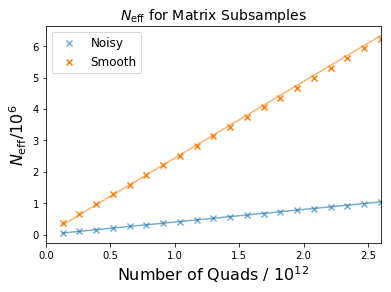

In [916]:
counts=samples_all*total_counts/max(samples_all)/1e12
plt.scatter(counts,N_effs_big_mock/1e6,alpha=0.6,marker='x',label='Noisy')
plt.plot(counts,counts*np.mean(N_effs_big_mock/1e6/counts),alpha=0.6)
plt.scatter(counts,N_effs_big_mean/1e6,label='Smooth',marker='x')
plt.plot(counts,counts*np.mean(N_effs_big_mean/1e6/counts),alpha=0.6)
plt.xlim([0,2.6])
##plt.ylim([0,600000])
plt.ylabel(r'$N_\mathrm{eff} / 10^6$',fontsize=16)
plt.legend(fontsize=12);#plt.yscale('log');plt.xscale('log')
plt.xlabel(r'Number of Quads / $10^{12}$',fontsize=16);plt.title(r'$N_\mathrm{eff}$ for Matrix Subsamples',fontsize=14);
#plt.savefig("../../plots/N_eff_vs_Quads_Fine.pdf")

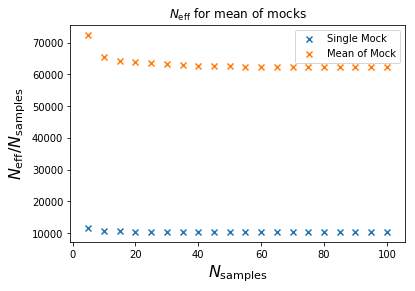

In [917]:
#plt.scatter(samples_all,N_effs,alpha=0.6,marker='x',label='Mock Mean')
#plt.plot(samples_all,samples_all*np.mean(N_effs/samples_all))
plt.scatter(samples_all,N_effs_big_mock/samples_all,label='Single Mock',marker='x')
plt.scatter(samples_all,N_effs_big_mean/samples_all,label='Mean of Mock',marker='x')
#plt.plot(samples_indivs,samples_indivs*np.mean(mean_N_effs/samples_indivs))
plt.ylabel(r'$N_\mathrm{eff}/N_\mathrm{samples}$',fontsize=16)
plt.legend();#plt.yscale('log');plt.xscale('log')
plt.xlabel(r'$N_\mathrm{samples}$',fontsize=16);plt.title(r'$N_\mathrm{eff}$ for mean of mocks');